In [47]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler,MinMaxScaler,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [72]:
df = pd.read_csv('../data/pet_adoption_data.csv')

print(f'Number of rows {df.shape[0]} and Number of col {df.shape[1]}')

df.head(5)

Number of rows 2007 and Number of col 13


,pet_id,pet_type,breed,age_months,color,size,weight_kg,vaccinated,health_condition,timein_shelter_days,adoption_fee,previous_owner,adoption_likelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0


In [73]:
df.drop('pet_id',axis=1,inplace=True)

<Axes: xlabel='adoption_likelihood', ylabel='count'>

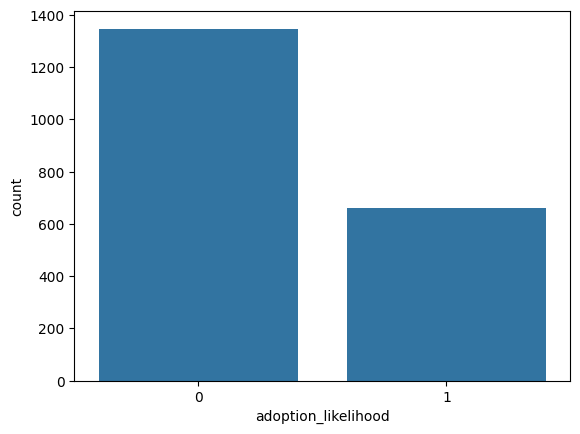

In [74]:
sns.barplot(df['adoption_likelihood'].value_counts())

<Axes: xlabel='adoption_fee', ylabel='Count'>

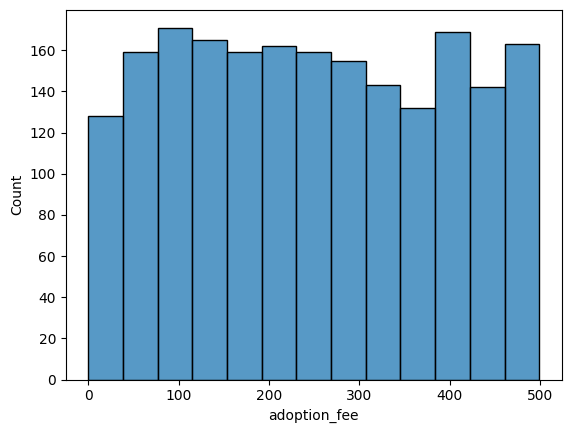

In [75]:
sns.histplot(df['adoption_fee'])

<Axes: xlabel='age_months', ylabel='Count'>

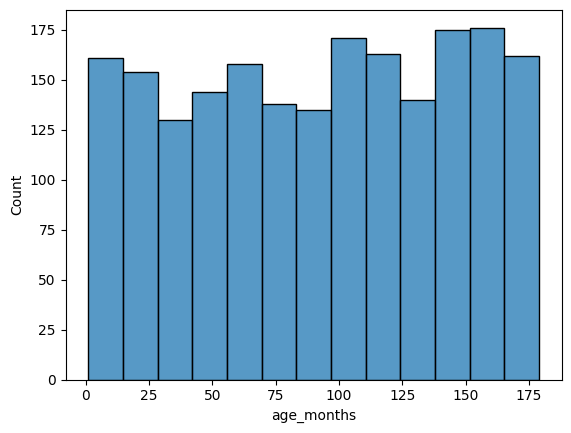

In [76]:
sns.histplot(df.age_months)

In [77]:
x = df.drop('adoption_likelihood',axis=1)
y = df['adoption_likelihood']

cat_nominal_feature = x.select_dtypes(include='object').columns.drop('size')
cat_oder_feature = x.select_dtypes(include='object').columns
cat_oder_feature  = [col for col in cat_oder_feature if col == 'size']
num_feature = x.select_dtypes(exclude='object').columns.drop('weight_kg')
min_max_feature = x.select_dtypes(exclude='object').columns
min_max_feature = [col for col in min_max_feature if col == 'weight_kg']

# cat_nominal_feature = x.select_dtypes(include='object').columns.drop('size')
# cat_oder_feature = ['size']
# num_feature = x.select_dtypes(exclude='object').columns.drop('weight_kg')
# min_max_feature = ['weight_kg']

cat_nominal_feature,cat_oder_feature,num_feature,min_max_feature

(Index(['pet_type', 'breed', 'color'], dtype='object'),
 ['size'],
 Index(['age_months', 'vaccinated', 'health_condition', 'timein_shelter_days',
        'adoption_fee', 'previous_owner'],
       dtype='object'),
 ['weight_kg'])

In [78]:
type(min_max_feature)

list

In [79]:
cat_order_feature = x.select_dtypes(include='object').drop(columns=['pet_type','breed','color']).columns
type(cat_order_feature)

pandas.core.indexes.base.Index

In [80]:
transf = ColumnTransformer(
    [
        ('nominal',OneHotEncoder(),cat_nominal_feature),
        ('ordenal',OrdinalEncoder(),cat_oder_feature), # label encoding is not allowed inside 
        ('stand',StandardScaler(),num_feature),
        ('minmax',MinMaxScaler(),min_max_feature)
    ]
)

In [81]:
transf

ColumnTransformer(transformers=[('nominal', OneHotEncoder(),
                                 Index(['pet_type', 'breed', 'color'], dtype='object')),
                                ('ordenal', OrdinalEncoder(), ['size']),
                                ('stand', StandardScaler(),
                                 Index(['age_months', 'vaccinated', 'health_condition', 'timein_shelter_days',
       'adoption_fee', 'previous_owner'],
      dtype='object')),
                                ('minmax', MinMaxScaler(), ['weight_kg'])])

In [82]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train = transf.fit_transform(x_train)
x_test = transf.transform(x_test)

In [83]:
model = DecisionTreeClassifier()

model.fit(x_train,y_train)

y_pred = model.predict(x_test)

acc = accuracy_score(y_test,y_pred)
print(f'Test Accuracy is {round(acc*100,2)}')

Test Accuracy is 87.81


In [84]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       270
           1       0.79      0.86      0.82       132

    accuracy                           0.88       402
   macro avg       0.86      0.87      0.86       402
weighted avg       0.88      0.88      0.88       402



<Axes: >

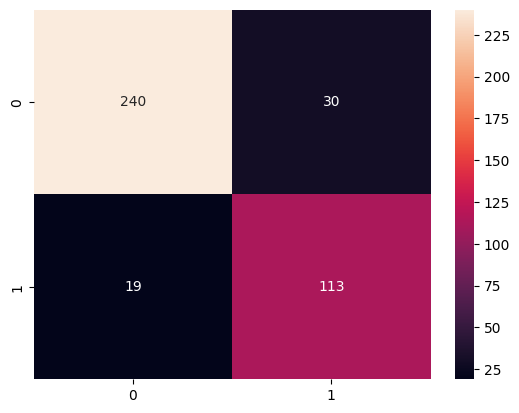

In [85]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

In [86]:
df['size'].unique()

array(['Large', 'Medium', 'Small'], dtype=object)

In [87]:
# Map Size

df['size_number'] = LabelEncoder().fit_transform(df['size'])

# or

df['size_num'] = df['size'].map({'Small':1,'Medium':2,'Large':3})

# encode rest
df.drop('size',axis=1,inplace=True)

df_encode = pd.get_dummies(df,columns=['pet_type', 'breed', 'color'],drop_first=True,dtype=int)

df_encode


,age_months,weight_kg,vaccinated,health_condition,timein_shelter_days,adoption_fee,previous_owner,adoption_likelihood,size_number,size_num,pet_type_Cat,pet_type_Dog,pet_type_Rabbit,breed_Labrador,breed_Parakeet,breed_Persian,breed_Poodle,breed_Rabbit,breed_Siamese,color_Brown,color_Gray,color_Orange,color_White
0,131,5.039768,1,0,27,140,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,1,0
1,73,16.086727,0,0,8,235,0,0,0,3,0,0,1,0,0,0,0,1,0,0,0,0,1
2,136,2.076286,0,0,85,385,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,1,0
3,97,3.339423,0,0,61,217,1,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,123,20.498100,0,0,28,14,1,0,0,3,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,72,27.039045,1,0,66,26,1,1,2,1,0,1,0,0,0,0,1,0,0,0,0,1,0
2003,124,4.726954,1,1,59,150,0,0,2,1,0,0,1,0,0,0,0,1,0,1,0,0,0
2004,113,1.758592,1,0,68,302,0,0,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0
2005,12,20.961592,1,0,59,478,0,0,0,3,0,1,0,1,0,0,0,0,0,0,1,0,0


In [88]:
df_encode.drop('size_number',axis=1,inplace=True)

In [92]:
minmax = MinMaxScaler()
scale = StandardScaler()

df_encode['weight_kg'] = minmax.fit_transform(df_encode[['weight_kg']])
df_encode['adoption_fee'] = scale.fit_transform(df_encode[['adoption_fee']])

df_encode.head()

,age_months,weight_kg,vaccinated,health_condition,timein_shelter_days,adoption_fee,previous_owner,adoption_likelihood,size_num,pet_type_Cat,pet_type_Dog,pet_type_Rabbit,breed_Labrador,breed_Parakeet,breed_Persian,breed_Poodle,breed_Rabbit,breed_Siamese,color_Brown,color_Gray,color_Orange,color_White
0,131,0.138783,1,0,27,-0.764025,0,0,3,0,0,0,0,1,0,0,0,0,0,0,1,0
1,73,0.520009,0,0,8,-0.098998,0,0,3,0,0,1,0,0,0,0,1,0,0,0,0,1
2,136,0.036514,0,0,85,0.951044,0,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0
3,97,0.080105,0,0,61,-0.225003,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,123,0.672244,0,0,28,-1.646060,1,0,3,0,0,1,0,0,0,0,1,0,0,1,0,0


In [93]:
x = df_encode.drop('adoption_likelihood',axis=1)
y = df_encode['adoption_likelihood']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

model = DecisionTreeClassifier()

model.fit(x_train,y_train)

y_pred = model.predict(x_test)

acc = accuracy_score(y_test,y_pred)
print(f'Test Accuracy is {round(acc*100,2)}')

Test Accuracy is 89.3


In [94]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       270
           1       0.83      0.85      0.84       132

    accuracy                           0.89       402
   macro avg       0.88      0.88      0.88       402
weighted avg       0.89      0.89      0.89       402



<Axes: >

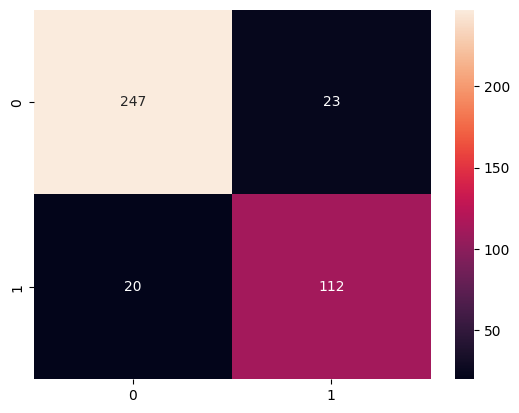

In [95]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')